# PV Production Prediction with Logistic Regression

Logistic regression model to predict normalized PV production values [0, 1] based on weather conditions using sigmoid activation.

## 1 - Packages

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

## 2 - Load and Explore Data

In [109]:
# Load data
data = pd.read_excel('Data/RawData.xlsx')

print(f"Dataset shape: {data.shape}")
print(f"\nColumns: {data.columns.tolist()}")
print(f"\nFirst rows:\n{data.head()}")

Dataset shape: (4803, 9)

Columns: ['time', 'Temperature_celcius', 'Rain_mm_per_h', 'Snow_mm_per_h', 'Air density_kg_per_m3', 'Ground_level_solar_irradiance_W_per_m2', 'Cloud_cover_fraction', 'wind_speed_m_per_s', 'electricity_kW']

First rows:
                  time  Temperature_celcius  Rain_mm_per_h  Snow_mm_per_h  \
0  2019-01-01 07:00:00                5.339          0.010            0.0   
1  2019-01-01 08:00:00                5.383          0.024            0.0   
2  2019-01-01 09:00:00                5.719          0.027            0.0   
3  2019-01-01 10:00:00                6.099          0.018            0.0   
4  2019-01-01 11:00:00                6.066          0.012            0.0   

   Air density_kg_per_m3  Ground_level_solar_irradiance_W_per_m2  \
0                  1.251                                   1.270   
1                  1.250                                  28.815   
2                  1.248                                  55.112   
3                  1

## 3 - Data Preprocessing

We normalize production values to [0, 1] range for logistic regression.

In [110]:
# Filter out zero production values
data_filtered = data[data['electricity_kW'] > 0].copy()

print(f"Original dataset: {len(data)} samples")
print(f"After filtering zeros: {len(data_filtered)} samples")

# Extract features (X) and target (y)
X = data_filtered[['Temperature_celcius', 'Rain_mm_per_h', 'Snow_mm_per_h', 
          'Air density_kg_per_m3', 'Ground_level_solar_irradiance_W_per_m2', 
          'Cloud_cover_fraction', 'wind_speed_m_per_s']].values

y_raw = data_filtered['electricity_kW'].values

# Normalize production values to [0, 1] for logistic regression
y_min, y_max = y_raw.min(), y_raw.max()
y = (y_raw - y_min) / (y_max - y_min)

print(f"\nOriginal production range: {y_raw.min():.2f} - {y_raw.max():.2f} kW")
print(f"Normalized production range: {y.min():.2f} - {y.max():.2f}")
print(f"\nProduction statistics (normalized):")
print(f"  Mean: {y.mean():.4f}")
print(f"  Median: {np.median(y):.4f}")
print(f"  Std: {y.std():.4f}")

Original dataset: 4803 samples
After filtering zeros: 4095 samples

Original production range: 0.00 - 8.45 kW
Normalized production range: 0.00 - 1.00

Production statistics (normalized):
  Mean: 0.3324
  Median: 0.2497
  Std: 0.2884


### Train/Test Split and Normalization

In [111]:
# 80-20 random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

print(f"Training samples: {len(X_train_norm)}")
print(f"Test samples: {len(X_test_norm)}")
print(f"X_train shape: {X_train_norm.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Feature range: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Training samples: 3276
Test samples: 819
X_train shape: (3276, 7)
y_train shape: (3276,)
Feature range: [0.00, 1.00]


## 4 - Building the Logistic Regression Model

We implement a logistic regression model for continuous prediction using sigmoid activation to constrain outputs to [0, 1].

## 5 - Train the Model

In [138]:
# Logistic Regression for continuous values using sklearn's SGDRegressor
from sklearn.linear_model import SGDRegressor

# Create logistic regression model for regression (outputs constrained to [0,1])
# We use SGD with log loss and modify to work like logistic regression
model = SGDRegressor(
    loss='squared_error',  # MSE loss
    penalty='l2',          # L2 regularization
    alpha=0.0004,         # Regularization strength
    max_iter=200000,
    tol=1e-3,
    random_state=42
)

# Train the model
model.fit(X_train_norm, y_train)

# Make predictions and clip to [0, 1] range
y_pred_train_raw = model.predict(X_train_norm)
y_pred_test_raw = model.predict(X_test_norm)

# Clip predictions to [0, 1] range (logistic constraint)
y_pred_train = np.clip(y_pred_train_raw, 0, 1)
y_pred_test = np.clip(y_pred_test_raw, 0, 1)

# Calculate regression metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training Set (normalized [0,1]):")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")

print("\nTest Set (normalized [0,1]):")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")

# Convert back to kW for interpretation
y_pred_test_kw = y_pred_test * (y_max - y_min) + y_min
y_test_kw = y_test * (y_max - y_min) + y_min
test_rmse_kw = np.sqrt(mean_squared_error(y_test_kw, y_pred_test_kw))
test_mae_kw = mean_absolute_error(y_test_kw, y_pred_test_kw)

print("\nTest Set (in kW):")
print(f"  RMSE: {test_rmse_kw:.4f} kW")
print(f"  MAE: {test_mae_kw:.4f} kW")

print(f"\nModel trained successfully!")

Training Set (normalized [0,1]):
  R² Score: 0.8879
  RMSE: 0.0961
  MAE: 0.0695

Test Set (normalized [0,1]):
  R² Score: 0.8890
  RMSE: 0.0978
  MAE: 0.0701

Test Set (in kW):
  RMSE: 0.8266 kW
  MAE: 0.5920 kW

Model trained successfully!


## 6 - Results Analysis

### Model Coefficients

Visualize feature importance - positive coefficients increase production, negative decrease it.

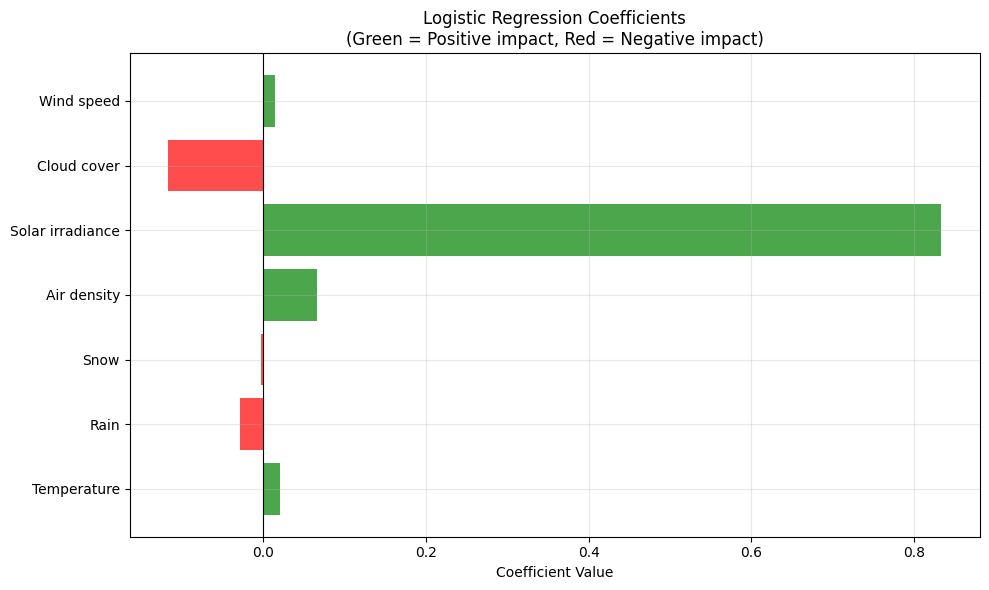

Regression Coefficients:
  Temperature         :   0.0205
  Rain                :  -0.0291
  Snow                :  -0.0026
  Air density         :   0.0656
  Solar irradiance    :   0.8334
  Cloud cover         :  -0.1168
  Wind speed          :   0.0147

Intercept: 0.0556


In [121]:
# Get feature names
feature_names = ['Temperature', 'Rain', 'Snow', 'Air density', 
                'Solar irradiance', 'Cloud cover', 'Wind speed']

# Plot regression coefficients
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red' if c < 0 else 'green' for c in model.coef_]
ax.barh(feature_names, model.coef_, color=colors, alpha=0.7)
ax.set_xlabel('Coefficient Value')
ax.set_title('Logistic Regression Coefficients\n(Green = Positive impact, Red = Negative impact)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Regression Coefficients:")
for name, coef in zip(feature_names, model.coef_):
    print(f"  {name:20s}: {coef:8.4f}")
print(f"\nIntercept: {model.intercept_[0]:.4f}")

### Prediction vs Actual Values

Compare predicted values (normalized [0,1]) with actual values on the test set.

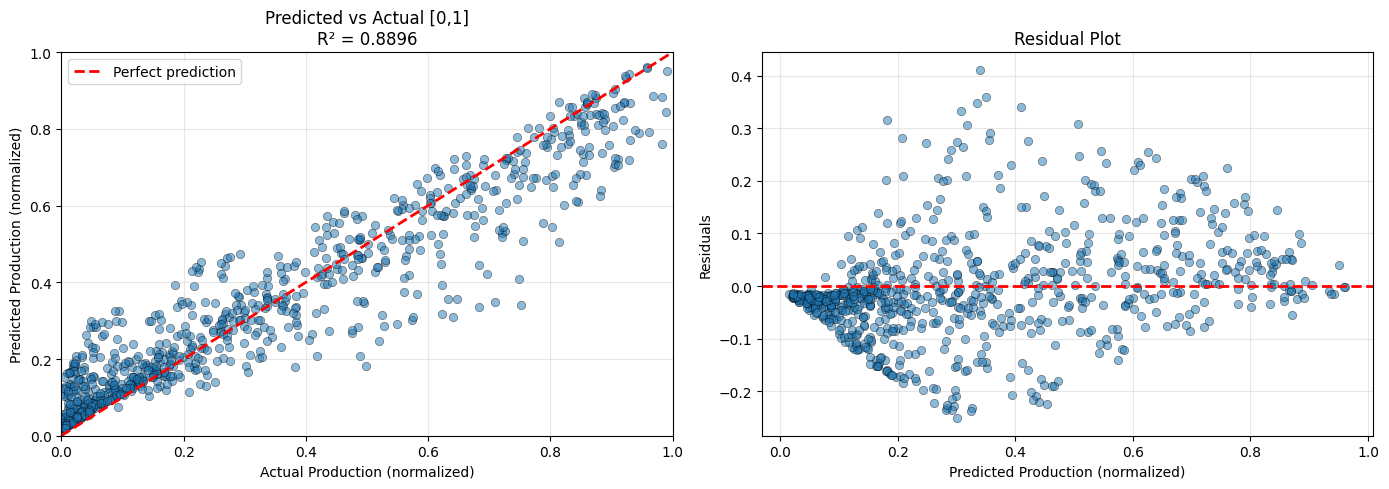

In [115]:
# Plot predicted vs actual values (normalized)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual (normalized [0,1])
axes[0].scatter(y_test, y_pred_test, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Production (normalized)')
axes[0].set_ylabel('Predicted Production (normalized)')
axes[0].set_title(f'Predicted vs Actual [0,1]\nR² = {test_r2:.4f}')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Production (normalized)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Sample Predictions

Show some example predictions from the test set.

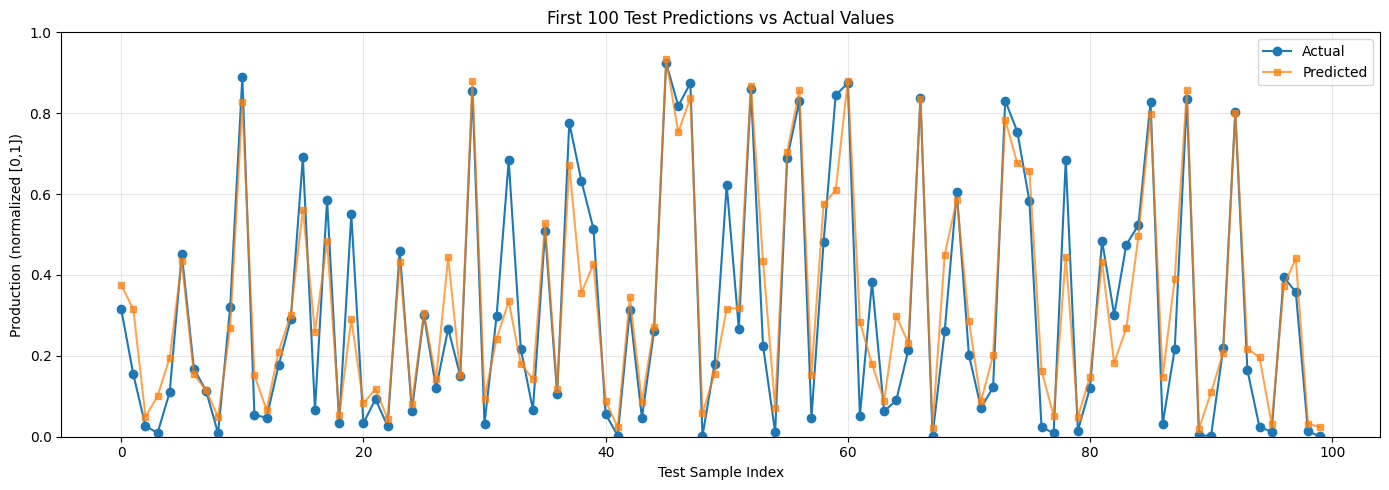


Sample Predictions (first 10):
Index | Actual [0,1] | Predicted [0,1] | Error | Actual kW | Predicted kW
-------------------------------------------------------------------------------------
    0 |       0.3153 |          0.3755 | -0.0603 |     2.665 |        3.174
    1 |       0.1541 |          0.3150 | -0.1609 |     1.303 |        2.663
    2 |       0.0269 |          0.0497 | -0.0228 |     0.228 |        0.421
    3 |       0.0092 |          0.1000 | -0.0908 |     0.079 |        0.846
    4 |       0.1097 |          0.1951 | -0.0854 |     0.928 |        1.650
    5 |       0.4514 |          0.4337 | 0.0176 |     3.815 |        3.666
    6 |       0.1684 |          0.1545 | 0.0139 |     1.424 |        1.307
    7 |       0.1141 |          0.1155 | -0.0014 |     0.965 |        0.977
    8 |       0.0085 |          0.0492 | -0.0407 |     0.073 |        0.417
    9 |       0.3202 |          0.2694 | 0.0508 |     2.707 |        2.278


In [119]:
# Show first 50 predictions
n_samples = 100
x_pos = np.arange(n_samples)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(x_pos, y_test[:n_samples], 'o-', label='Actual', markersize=6, linewidth=1.5)
ax.plot(x_pos, y_pred_test[:n_samples], 's-', label='Predicted', markersize=5, linewidth=1.5, alpha=0.7)
ax.set_xlabel('Test Sample Index')
ax.set_ylabel('Production (normalized [0,1])')
ax.set_title(f'First {n_samples} Test Predictions vs Actual Values')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some examples
print("\nSample Predictions (first 10):")
print("Index | Actual [0,1] | Predicted [0,1] | Error | Actual kW | Predicted kW")
print("-" * 85)
for i in range(10):
    error = y_test[i] - y_pred_test[i]
    actual_kw = y_test[i] * (y_max - y_min) + y_min
    pred_kw = y_pred_test[i] * (y_max - y_min) + y_min
    print(f"{i:5d} | {y_test[i]:12.4f} | {y_pred_test[i]:15.4f} | {error:5.4f} | {actual_kw:9.3f} | {pred_kw:12.3f}")

### Error Distribution

Analyze the distribution of prediction errors.

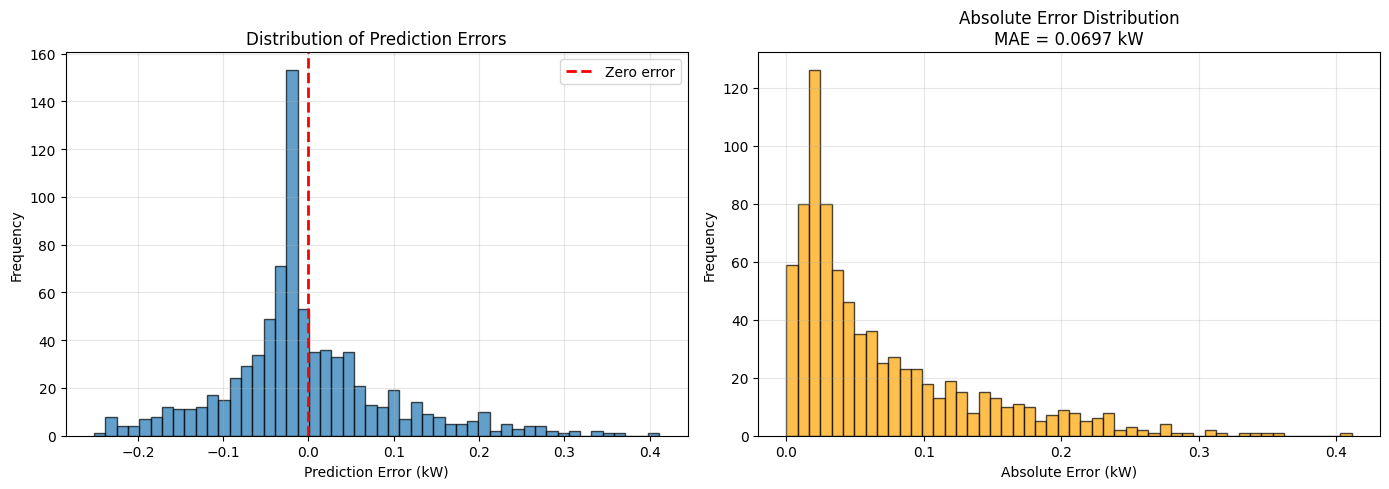


Error Statistics:
  Mean Error: -0.0047 kW
  Std Error: 0.0974 kW
  Max Error: 0.4114 kW
  Median Absolute Error: 0.0425 kW


In [117]:
# Plot error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of errors
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero error')
axes[0].set_xlabel('Prediction Error (kW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Absolute error distribution
abs_errors = np.abs(residuals)
axes[1].hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Absolute Error (kW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Absolute Error Distribution\nMAE = {test_mae:.4f} kW')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"  Mean Error: {residuals.mean():.4f} kW")
print(f"  Std Error: {residuals.std():.4f} kW")
print(f"  Max Error: {abs_errors.max():.4f} kW")
print(f"  Median Absolute Error: {np.median(abs_errors):.4f} kW")

In [118]:
from sklearn.metrics import classification_report

print(classification_report(y_test.flatten(), result['y_pred_test'].flatten(),
                          target_names=['Low', 'Medium', 'High'],
                          labels=[0, 1, 2],
                          zero_division=0))

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets